In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score
from itertools import cycle
from tqdm import tqdm
import pandas as pd

# Загрузка набора данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Объединение и последующее разделение данных в соотношении 50/50
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

x_train, x_test = x[:25000], x[45000:]
y_train, y_test = y[:25000], y[45000:]

# Нормализация значений пикселей от 0 до 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Преобразование изображений в 4D массивы (количество изображений, высота, ширина, количество каналов)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Преобразование меток в one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Определение улучшенной архитектуры нейронной сети
class ImprovedConvNet(tf.keras.Model):
    def __init__(self):
        super(ImprovedConvNet, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Инициализация модели и параметров
model = ImprovedConvNet()

# Функция вычисления потерь
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Оптимизатор (не используется для обновления весов, но нужен для градиентов)
optimizer = tf.keras.optimizers.Adam()

# Прямое распространение и вычисление потерь с использованием tf.function
@tf.function
def compute_loss_and_gradients(model, x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# Сортировка весов по важности (сумма абсолютных значений градиентов)
def sort_weights_by_importance(gradients):
    importance = {i: np.sum(np.abs(grad.numpy())) for i, grad in enumerate(gradients)}
    sorted_weights = sorted(importance.items(), key=lambda item: item[1], reverse=True)
    return sorted_weights

# Получение важных весов
def get_important_weights(gradients, threshold=0.6):
    sorted_weights = sort_weights_by_importance(gradients)
    total_importance = sum([item[1] for item in sorted_weights])
    accumulated_importance = 0
    important_weights = []
    
    for idx, importance in sorted_weights:
        accumulated_importance += importance
        important_weights.append(idx)
        if accumulated_importance / total_importance >= threshold:
            break

    return important_weights

# Функция вычисления правдоподобия
def compute_log_likelihood(y_true, y_pred):
    likelihood = np.sum(y_true * np.log(y_pred + 1e-9))  # Добавление маленького значения для стабильности
    return likelihood

# Семплирование Метрополиса-Хастингса с подготовкой весов
def metropolis_hastings_step(model, x_train, y_train, sigmas, important_weights):
    new_weights = []
    for idx, (weight, sigma) in enumerate(zip(model.get_weights(), sigmas)):
        if important_weights and idx in important_weights:
            new_weight = weight + np.random.normal(0, sigma, weight.shape)
        else:
            new_weight = weight
        new_weights.append(new_weight)
    
    model.set_weights(new_weights)
    new_loss, new_gradients = compute_loss_and_gradients(model, x_train, y_train)
    return new_loss, new_gradients

def metropolis_hastings(model, x_train, y_train, x_test, y_test, sigma_origin, sigma_delta, n_iter=1000, burn_in=100, important_after_iter=100):
    y_train_pred = model(x_train, training=False).numpy()
    current_log_likelihood = compute_log_likelihood(y_train, y_train_pred)
    best_log_likelihood = current_log_likelihood
    best_weights = model.get_weights()
    sigmas = [sigma_origin * np.ones_like(weight) for weight in model.get_weights()]
    accepted = 0
    test_accs = []
    sigma_means = []
    samples = []
    
    important_weights = None

    for i in tqdm(range(n_iter)):
        if i == important_after_iter:
            current_gradients = compute_loss_and_gradients(model, x_train, y_train)
            important_weights = get_important_weights(current_gradients)

        new_weights = []
        for idx, (weight, sigma) in enumerate(zip(model.get_weights(), sigmas)):
            if important_weights and idx in important_weights:
                new_weight = weight + np.random.normal(0, sigma, weight.shape)
            else:
                new_weight = weight
            new_weights.append(new_weight)
        
        model.set_weights(new_weights)
        new_gradients = compute_loss_and_gradients(model, x_train, y_train)

        # Вычисление правдоподобия
        y_train_pred_new = model(x_train, training=False).numpy()
        new_log_likelihood = compute_log_likelihood(y_train, y_train_pred_new)
        
        accept_prob = np.min([1, np.exp(new_log_likelihood - current_log_likelihood)])
        if np.random.uniform() < accept_prob:
            current_log_likelihood = new_log_likelihood
            accepted += 1  
            if best_log_likelihood < new_log_likelihood:
                best_log_likelihood = new_log_likelihood
                best_weights = new_weights
        else:
            model.set_weights(best_weights)

        if i >= burn_in:
            test_pred = model(x_test, training=False)
            test_acc = np.mean(np.argmax(test_pred.numpy(), axis=1) == np.argmax(y_test, axis=1))
            test_accs.append(test_acc)

            sigma_mean = np.mean([np.mean(np.abs(s)).astype(np.float32) for s in sigmas])
            sigma_means.append(sigma_mean)

            sample = {
                'likelihood': np.exp(current_log_likelihood / y_train.shape[0]),
                'test_acc': test_acc,
                'train_acc': np.mean(np.argmax(model(x_train, training=False).numpy(), axis=1) == np.argmax(y_train, axis=1))
            }
            samples.append(sample)

        sigmas = [np.maximum(0.001, sigma + np.random.normal(0, sigma_delta, sigma.shape)) for sigma in sigmas]

    samples_df = pd.DataFrame(samples)
    accept_rate = (accepted / n_iter)
    model.set_weights(best_weights)
    
    return model, sigma_means, test_accs, accept_rate, samples_df, important_weights

def evaluate_model(model, best_weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights):
    model.set_weights(best_weights)
    
    # Оценка на тестовых данных
    test_pred = model(x_test, training=False)
    test_acc = np.mean(np.argmax(test_pred.numpy(), axis=1) == np.argmax(y_test, axis=1))
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred.numpy(), axis=1), average='weighted')
    
    # Оценка на тренировочных данных
    train_pred = model(x_train, training=False)
    train_acc = np.mean(np.argmax(train_pred.numpy(), axis=1) == np.argmax(y_train, axis=1))
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred.numpy(), axis=1), average='weighted')
    
    # Вывод результатов
    print(f'Точность на тестовых данных: {test_acc * 100:.2f}%')
    print(f'F1-score на тестовых данных: {test_f1:.2f}')
    print(f'Процент принятия: {accept_rate * 100:.2f}%')
    print(f'Точность на тренировочных данных: {train_acc * 100:.2f}%')
    print(f'F1-score на тренировочных данных: {train_f1:.2f}')

    total_params = sum([np.prod(v.shape) for v in best_weights])
    
    if important_weights is not None:
        important_params = sum([np.prod(model.get_weights()[idx].shape) for idx in important_weights])
        percent_important_weights = (important_params / total_params) * 100
        print(f'Общее количество параметров: {total_params}')
        print(f'Количество важных параметров: {important_params}')
        print(f'Процент важных параметров: {percent_important_weights:.2f}%')
    else:
        print(f'Общее количество параметров: {total_params}')
        print('Важные параметры не были выделены.')
    
    max_acc_index = np.argmax(test_accs)
    sigma_mean_at_max_acc = sigma_means[max_acc_index]
    print(f'Среднее значение сигмы при максимальной точности на тестовых данных: {sigma_mean_at_max_acc}')

    plt.figure()
    plt.plot(sigma_means, test_accs)
    plt.xlabel('Среднее значение стандартных отклонений')
    plt.ylabel('Точность предсказаний на тестовой выборке')
    plt.title('Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений')
    plt.savefig('Conv 70k Точность предсказаний на тестовой выборке от среднего значения стандартных отклонений.png')
    plt.show()

    # Динамика значений функции правдоподобия от числа итераций
    plt.figure()
    plt.plot(samples_df['likelihood'])
    plt.xlabel('Итерация')
    plt.ylabel('Значения функции правдоподобия')
    plt.title('Динамика значений функции правдоподобия от числа итераций')
    plt.savefig('Conv 70k Динамика значений функции правдоподобия от числа итераций.png')
    plt.show()

    # ROC-кривая и AUC для тестовых данных
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_pred = test_pred.numpy()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Построение ROC-кривой
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'yellow', 'brown', 'pink', 'gray'])
    for i, color in zip(range(10), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC-кривая класса {i} (площадь = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Частота ложных срабатываний')
    plt.ylabel('Частота истинных срабатываний')
    plt.title('ROC-кривая для мультиклассовой классификации')
    plt.legend(loc='lower right')
    plt.savefig('Conv 70k ROC-кривая для мультиклассовой классификации.png')
    plt.show()

    # Значения точности предсказаний на обучающей от значений функции правдоподобия
    plt.figure()
    plt.scatter(np.exp(samples_df['likelihood']), samples_df['train_acc'])
    plt.xlabel('Значения функции правдоподобия')
    plt.ylabel('Точность предсказаний на обучающей выборке')
    plt.title('Значения точности предсказаний на обучающей от значений функции правдоподобия')
    plt.savefig('Conv 70k Значения точности предсказаний на обучающей от значений функции правдоподобия.png')
    plt.show()

    # Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(samples_df['likelihood'], color='b', label='Правдоподобие')
    ax1.set_xlabel('Итерации')
    ax1.set_ylabel('Правдоподобие', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax2 = ax1.twinx()  
    ax2.plot(samples_df['train_acc'], color='r', label='Точность на тренировочных данных')
    ax2.plot(samples_df['test_acc'], color='g', label='Точность на тестовых данных')
    ax2.set_ylabel('Точность', color='black')  
    ax2.tick_params(axis='y', labelcolor='black')
    fig.suptitle('Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.savefig('Conv 70k Динамика значений функции правдоподобия и точностей на обучающих и тестовых выборках от числа итераций.png')
    plt.show()

    # Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия
    fig2, ax4 = plt.subplots(figsize=(10, 6))
    ax4.scatter(np.log(samples_df['likelihood']), samples_df['train_acc'], s=1, label='Точность на тренировочных данных', color='b')
    ax4.set_xlabel('Логарифмированное правдоподобие')
    ax4.set_ylabel('Точность на тренировочных данных', color='b')
    ax4.tick_params(axis='y', labelcolor='b')

    ax5 = ax4.twinx()
    ax5.scatter(np.log(samples_df['likelihood']), samples_df['test_acc'], s=1, label='Точность на тестовых данных', color='g')
    ax5.set_ylabel('Точность на тестовых данных', color='g')
    ax5.tick_params(axis='y', labelcolor='g')

    fig2.suptitle('Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия')
    lines, labels = ax4.get_legend_handles_labels()
    lines2, labels2 = ax5.get_legend_handles_labels()
    ax4.legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    plt.savefig('Conv 70k Изменение точности предсказаний на тестовых и обучающих выборках от логарифмического правдоподобия.png')
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [30:54:17<00:00,  2.23s/it]


Точность на тестовых данных: 96.47%
F1-score на тестовых данных: 0.96
Процент принятия: 15.62%
Точность на тренировочных данных: 96.87%
F1-score на тренировочных данных: 0.97
Общее количество параметров: 244042
Количество важных параметров: 204800
Процент важных параметров: 83.92%
Среднее значение сигмы при максимальной точности на тестовых данных: 0.018847210332751274


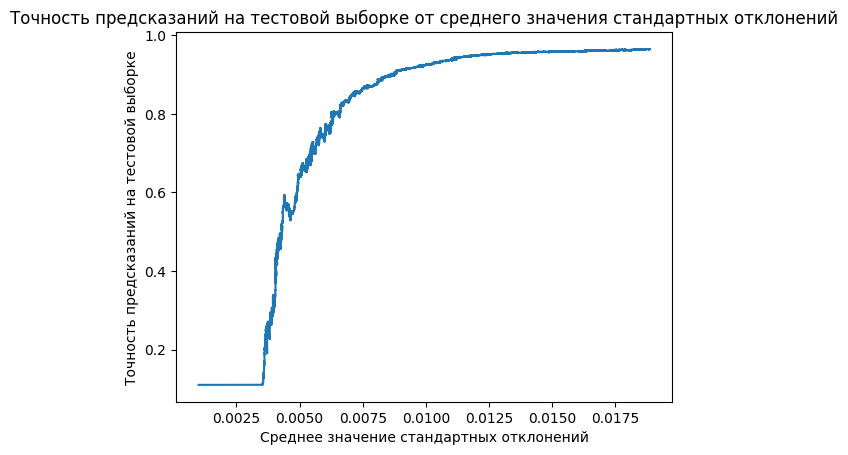

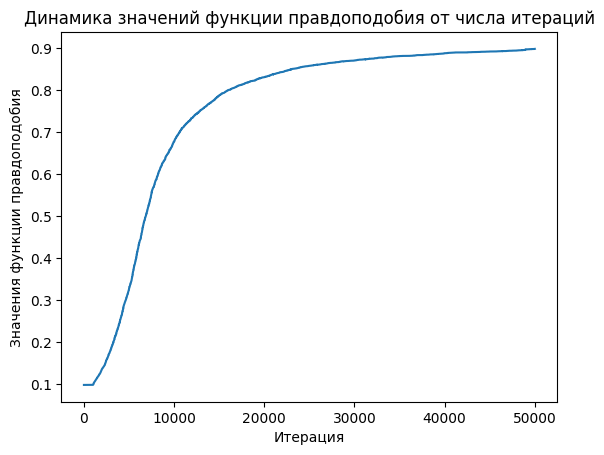

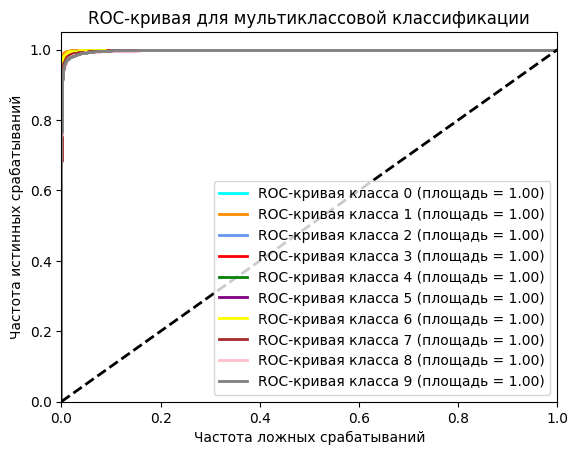

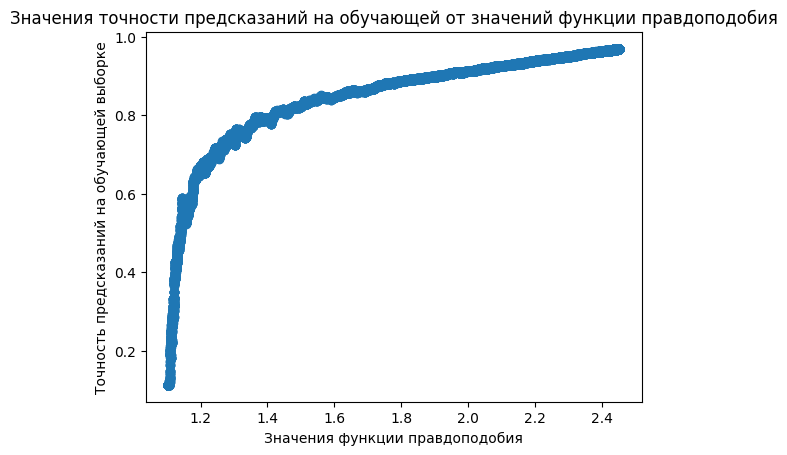

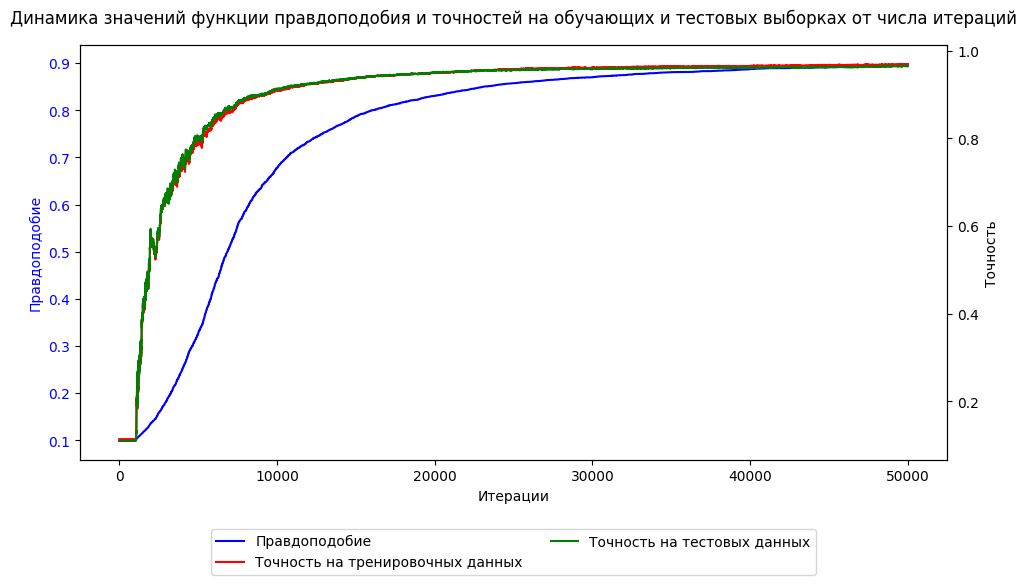

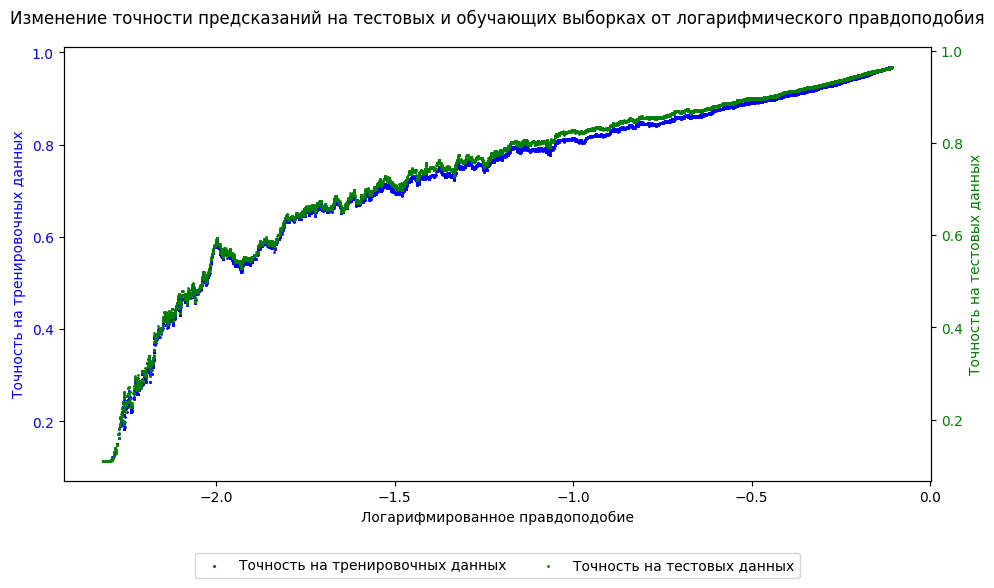

In [40]:
model, sigma_means, test_accs, accept_rate, samples_df, important_weights = metropolis_hastings(
    model, x_train, y_train, x_test, y_test, sigma_origin=0.001, sigma_delta=0.0001, n_iter=50000, burn_in=0, important_after_iter=1000)
best_weights = model.get_weights()
samples_df.to_csv('Conv_70k_samples_FINAL.csv', index=False)
evaluate_model(model, best_weights, sigma_means, test_accs, accept_rate, x_train, y_train, x_test, y_test, samples_df, important_weights)